# NYC Taxi Trip Duration — Predictive Regression Project

## 1. Introduction

Urban transportation systems generate massive amounts of trip data every day. Accurately predicting taxi trip duration is a critical component of intelligent transportation systems, influencing pricing strategies, driver allocation, customer satisfaction, and operational efficiency.

In this project, we leverage historical New York City taxi trip records to build a robust predictive regression framework that estimates exactly how long a taxi ride will take based on spatial, temporal, and traffic-related features.

---

## 2. Business Problem

Taxi platforms and ride-hailing companies face several operational challenges heavily reliant on accurate time predictions:

* Customers require precise Estimated Times of Arrival (ETA) to build trust in the platform.
* Drivers need efficient trip planning and routing to maximize daily earnings.
* Companies must optimize surge pricing algorithms based on time-in-transit.
* Dispatch systems need reliable ETAs to anticipate when vehicles will re-enter the available fleet.

Failure to predict trip durations accurately can lead to:

* Poor customer experience due to wildly incorrect ETAs.
* Inefficient driver utilization and lower fleet turnover.
* Revenue loss from suboptimal pricing models.

---

## 3. Project Objectives

This project addresses the business problem by building a highly optimized regression pipeline. Instead of a single algorithm, we follow a progressive modeling approach:

### Phase 1 — Baseline Interpretable Modeling
Develop **Linear, Ridge, and Lasso Regression models** to establish a performance baseline, utilizing engineered spatial metrics (Manhattan Distance) and cyclic temporal features. This helps quantify the linear relationships between distance and time.

### Phase 2 — Advanced Non-Linear Modeling
Implement and tune advanced **Tree-Based Ensembles (XGBoost & LightGBM)** to capture the complex, non-linear realities of urban traffic (e.g., exponential delays during rush hour gridlock that linear models fail to predict).

---

## 4. Analytical Approach

To solve the problem, we will follow an end-to-end machine learning workflow:

1. **Data Cleaning & Preprocessing:** Handling severe spatial and temporal outliers (e.g., GPS errors, multi-day meter errors).
2. **Exploratory Data Analysis (EDA):** Visualizing distributions and target variable transformations (Log Transformation).
3. **Feature Engineering:** Creating domain-specific features such as Manhattan distance, cyclical time transformations (sine/cosine), and daily traffic intensity proxies.
4. **Baseline Modeling:** Training and evaluating Linear Regression and Regularized models (L1/L2).
5. **Ensemble Modeling:** Training Gradient Boosting Machines (XGBoost/LightGBM) to minimize prediction error on complex routes.
6. **Hyperparameter Tuning:** Applying RandomizedSearchCV and Cross-Validation to optimize the best model and strictly prevent overfitting.
7. **Evaluation:** Assessing models using business-interpretable metrics (MAE, RMSE in actual minutes) rather than relying solely on mathematical variance ($R^2$).

---

## 5. Expected Impact

By developing a highly accurate, generalized regression model, this project demonstrates how machine learning can directly solve logistical bottlenecks:

* Reduce ETA prediction errors to under a few minutes.
* Support operational decision-making for routing and dispatch.
* Enhance overall customer satisfaction through transparent and reliable forecasting.

---

In [ ]:
# Core Libraries
import numpy as np
import pandas as pd
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")
# Date & Time Handling
from datetime import datetime
# Train / Test Split & Validation
from sklearn.model_selection import train_test_split
# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
# Regression Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# Evaluation Metrics — Regression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
# Distance Calculation (Haversine)
from math import radians, cos, sin, asin, sqrt
# Warning Control
# ============================================
import warnings
warnings.filterwarnings("ignore")
## Extra libs
! pip install shap
!pip install xgboost lightgbm


In [2]:
data = pd.read_csv("data/train.csv")
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data['dropoff_datetime'] = pd.to_datetime(data['dropoff_datetime'])
data['pickup_date'] = data['pickup_datetime'].dt.date
data

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26
...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778,2016-04-08
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655,2016-01-10
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764,2016-04-22
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373,2016-01-05


In [3]:
print(f"The dataset has {data.shape[0]} rows and {data.shape[1]} columns" )
data.info()
data.head()


The dataset has 1458644 rows and 12 columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 12 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
 11  pickup_date         1458644 non-null  object        
dtypes: datetime64[ns](2), floa

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26


## Explanatory Data Analysis

### Target variable `trip_duration` - Liner regression

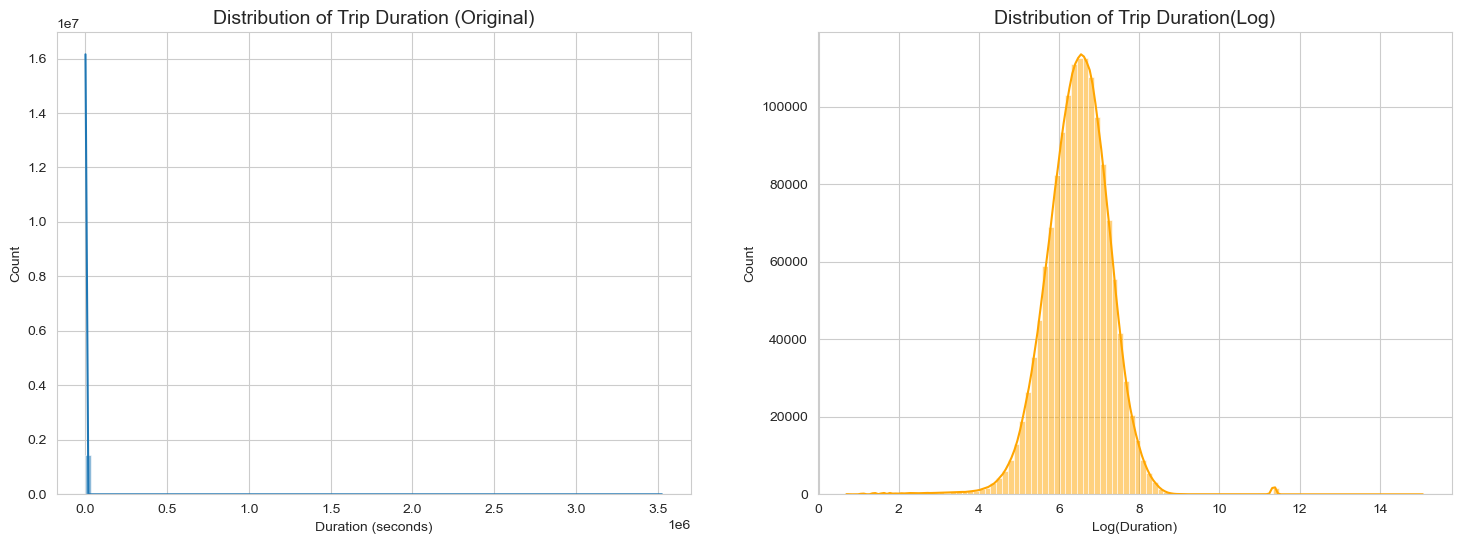

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Raw Duration
sns.histplot(data['trip_duration'], bins=100, kde=True, ax=ax[0])
ax[0].set_title('Distribution of Trip Duration (Original)', fontsize=14)
ax[0].set_xlabel('Duration (seconds)')

# Log-Transformed Duration
#use log1p to handle any potential 0 values safely
sns.histplot(np.log1p(data['trip_duration']), bins=100, kde=True, ax=ax[1], color='orange')
ax[1].set_title('Distribution of Trip Duration(Log)', fontsize=14)
ax[1].set_xlabel('Log(Duration)')

plt.show()

### **Interpretation & Observations:**

The target variable `trip_duration` measures the total time of a taxi trip in seconds. Analyzing its distribution is critical because linear regression models rely on assumptions about the target variable's distribution (normality) and sensitivity to outliers.

#### **1. Plot Analysis**

* **Left Plot (Original Scale):**
* **Visual:** The distribution is extremely **right-skewed**. A single massive bar exists near zero, with a flat tail extending all the way to  seconds (approx. 40 days).
* **Meaning:** The vast majority of trips are short (under 1 hour), but there are extreme outliers. These outliers likely represent data errors, such as drivers forgetting to log off, cars left running, or system glitches.
* **Impact:** If used directly, these massive values will "pull" the regression line, causing the model to severely overestimate the duration of normal trips.


* **Right Plot (Log-Transformed Scale):**
* **Visual:** After applying a logarithmic transformation (), the data forms a near-perfect **Normal Distribution (Bell Curve)**.
* **The "Bump":** Notice the small, detached cluster of data points on the far right (around log value 11-12). These correspond to the extreme outliers seen in the left plot.
* **Meaning:** The main body of taxi trips follows a log-normal distribution. This suggests that `log(duration)` is a much better target variable for training than the raw seconds.



#### **2. Key Observations**

1. **Extreme Outliers Detected:** The dataset contains physically impossible trip durations (e.g., > 1000 hours). These outliers must be removed to prevent model bias.
2. **Log-Normality:** The trip duration data is log-normally distributed. This confirms that **Linear Regression** should be trained on the **log-transformed target** rather than the raw duration to satisfy normality assumptions and improve prediction accuracy.
3. **Data Cleaning Strategy:** Based on the plots, we should apply a cutoff to remove the "bump" of outliers seen in the log plot. A reasonable upper bound (e.g., < 24 hours or the 99th percentile) will isolate the true taxi trips from the anomalies.

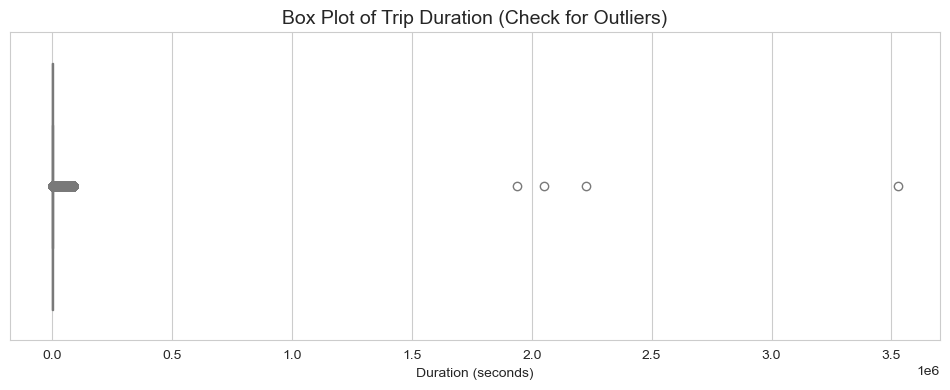

In [5]:
plt.figure(figsize=(12, 4))
sns.boxplot(x=data['trip_duration'], color='lightblue')
plt.title('Box Plot of Trip Duration (Check for Outliers)', fontsize=14)
plt.xlabel('Duration (seconds)')
plt.show()

### **Interpretation & Observations**

The box plot provides a different perspective on the distribution of `trip_duration`, specifically highlighting individual data points that deviate significantly from the norm.

#### **1. Plot Analysis**

* **Visual Compression:** The "box" part of the plot (representing the Interquartile Range, or the middle 50% of trips) is completely squashed against the left axis (near 0). This indicates that the vast majority of trips are extremely short compared to the scale of the outliers.
* **Extreme Outliers:** We can clearly identify four distinct, isolated data points on the far right of the chart:
* Three points cluster around **2,000,000 seconds**.
* One point sits near **3,500,000 seconds**.


**Observation:** It is physically impossible for a standard NYC taxi trip to last 23 or 40 days. These data points almost certainly represent:

* **System Errors:** GPS or meter malfunctions.
* **Human Error:** A driver forgetting to "end" a trip in the system for weeks.
* **Stolen/Lost Vehicles:** Cars that were active but not actually transporting a passenger.

**Impact on Modeling**

* **Mean vs. Median:** These massive values will skew the **Mean** (average) significantly higher than the **Median** (middle value).
* **RMSE Sensitivity:** Since our regression metric is often Root Mean Squared Error (RMSE), which penalizes large errors heavily, leaving these 40-day trips in the training data will destroy the model's ability to predict normal 15-minute trips.

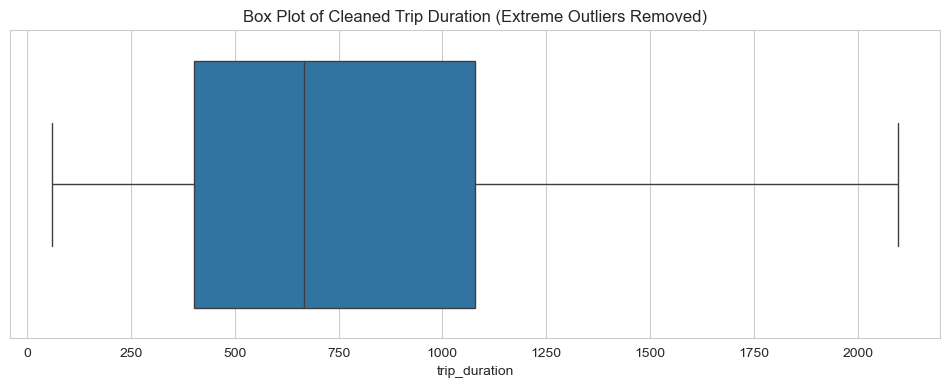

In [6]:
## data cleaning removing ouliers 
lower_lim = 60
upper_lim = 86400
data = data[(data['trip_duration'] > lower_lim) & (data['trip_duration'] < upper_lim)]

#verify using a boxplot
plt.figure(figsize=(12, 4))
sns.boxplot(x=data['trip_duration'], showfliers=False) # showfliers=False hides the standard statistical outliers to see the median better
plt.title('Box Plot of Cleaned Trip Duration (Extreme Outliers Removed)')
plt.show()

## Passenger Count

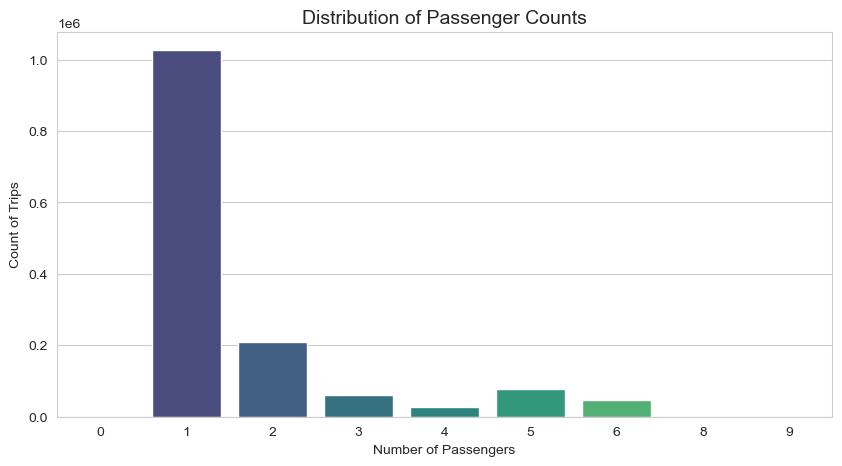

Number of trips with 0 passengers: 18


In [7]:
plt.figure(figsize=(10, 5))
sns.countplot(x='passenger_count', data=data, palette='viridis')
plt.title('Distribution of Passenger Counts', fontsize=14)
plt.xlabel('Number of Passengers')
plt.ylabel('Count of Trips')
plt.show()

zero_pass_count = data[data['passenger_count'] == 0].shape[0]
print(f"Number of trips with 0 passengers: {zero_pass_count}")

Standard NYC Yellow Cabs typically have a legal maximum of **4 passengers (sedans)** or **5-6 passengers (SUVs/Minivans)**.
trips with 8 or 9 passengers is highly suspicious and likely indicates data entry errors (e.g., a driver keying in the wrong number on the meter) or perhaps special, non-standard vehicles that shouldn't be in a general taxi dataset.

### **Interpretation & Observations: Passenger Count**

 **Observation: Passenger Count Analysis**
 1. **Zero-Passenger Trips:**
 * **Issue:** A valid taxi trip must have at least one passenger. Trips with `passenger_count = 0` are logically impossible for fare-generating rides.
 * **Cause:** These likely represent meter errors, cancelled trips where the meter was started, or system glitches.
 * **Action:** These rows must be removed.
 2. **High-Occupancy Outliers (8-9 Passengers):**
 * **Issue:** Standard NYC Yellow Cabs have a maximum legal capacity of 4 (sedans) or 5 (SUVs). Even larger accessible vans rarely exceed 6 passengers.
 * **Cause:** Values of 8 or 9 are likely **manual entry errors** by the driver (e.g., trying to type "0" or "1" and hitting the wrong key repeatedly) or rare, non-standard vehicles that don't represent the general fleet.
 * **Impact:** Including these rare cases could introduce noise, as the "rules" for these trips (loading times, vehicle speed) might differ significantly from standard taxis.
 * **Action:** We will cap the passenger count at roughly **6** to align with the maximum capacity of standard NYC taxi vans.

passenger_count
0         18
1    1026540
2     209405
3      59661
4      28282
5      77792
6      48163
8          1
9          1
Name: count, dtype: int64
passenger_count
1    1026540
2     209405
3      59661
4      28282
5      77792
6      48163
Name: count, dtype: int64


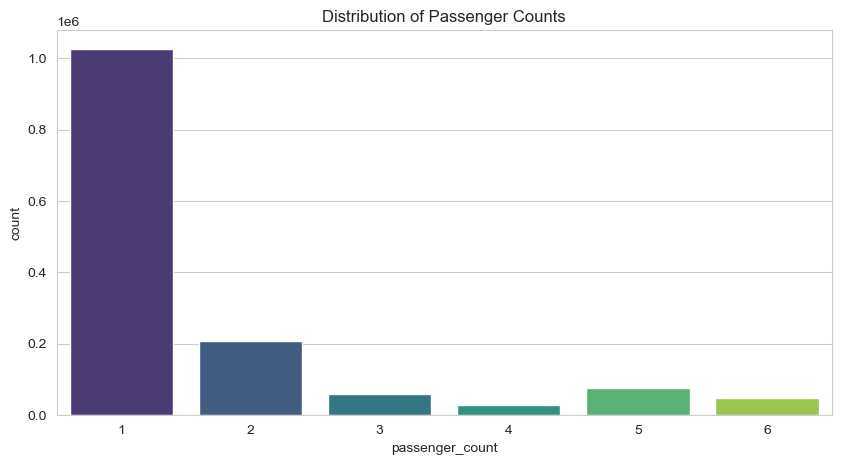

In [8]:
print(data['passenger_count'].value_counts().sort_index())
data = data[(data['passenger_count'] > 0) & (data['passenger_count'] <= 6)]
print(data['passenger_count'].value_counts().sort_index())
plt.figure(figsize=(10, 5))
sns.countplot(x='passenger_count', data=data, palette='viridis')
plt.title('Distribution of Passenger Counts')
plt.show()

## Handling Geospatial Outliers(boxing the dataset into NY-coordinates)

In [9]:
NYC_MIN_LAT, NYC_MAX_LAT = 40.57, 40.92  
NYC_MIN_LON, NYC_MAX_LON = -74.25, -73.70 

data_geo = data[
    (data['pickup_latitude'].between(NYC_MIN_LAT, NYC_MAX_LAT)) &
    (data['pickup_longitude'].between(NYC_MIN_LON, NYC_MAX_LON)) &
    (data['dropoff_latitude'].between(NYC_MIN_LAT, NYC_MAX_LAT)) &
    (data['dropoff_longitude'].between(NYC_MIN_LON, NYC_MAX_LON))
]

print(f"Original Row Count: {data.shape[0]}")
print(f"NYC-Only Row Count: {data_geo.shape[0]}")
print(f"Removed {data.shape[0] - data_geo.shape[0]} trips outside NYC boundaries.")

# Update the main dataframe
data = data_geo

Original Row Count: 1449843
NYC-Only Row Count: 1448611
Removed 1232 trips outside NYC boundaries.


## Trip Anomalies

6577.785123422049 9341.017074380148


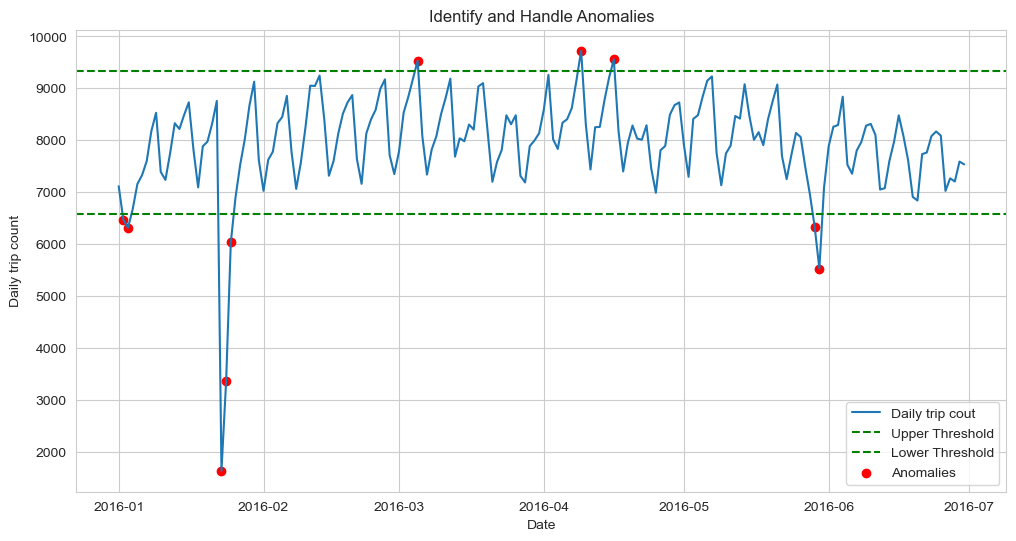

In [10]:
# Calculate daily trip counts
daily_trips = data.groupby('pickup_date').size().reset_index(name='trip_count')

# Calculate mean and standard deviation
mean_trips = daily_trips['trip_count'].mean()
std_trips = daily_trips['trip_count'].std()

#checking 1 through 3 
threshold = 1.5

lower_bound = mean_trips - threshold * std_trips
upper_bound = mean_trips + threshold * std_trips
print(lower_bound, upper_bound)
high_anomaly = daily_trips[daily_trips['trip_count'] > upper_bound]
low_anomaly = daily_trips[daily_trips['trip_count'] < lower_bound]

# Combine high and low anomalies
anomalous_days = pd.concat([high_anomaly, low_anomaly])

data['is_anomaly'] = 0
data.loc[data['pickup_date'].isin(anomalous_days['pickup_date']), 'is_anomaly'] = 1

# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(daily_trips['pickup_date'], daily_trips['trip_count'], label='Daily trip cout')
plt.axhline(y=lower_bound, color='g', linestyle='--', label='Upper Threshold')
plt.axhline(y=upper_bound,  color='g', linestyle='--', label='Lower Threshold')
plt.scatter(anomalous_days['pickup_date'], anomalous_days['trip_count'], color='red', label='Anomalies')
plt.title('Identify and Handle Anomalies')
plt.xlabel('Date')
plt.ylabel('Daily trip count')
plt.legend()
plt.show()

### **Anomaly Detection & Handling**

To ensure our model is robust to real-world events, we analyzed the daily volume of taxi trips to identify irregularities in traffic patterns.

#### **1. Analysis of Daily Trip Counts**

We calculated the daily trip frequency and plotted it against statistical thresholds (mean  1.5 standard deviations). The visualization revealed distinct "anomalies" that correspond to specific real-world events:

* **The "Blizzard Dip" (Jan 23–25, 2016):**
* **Observation:** A massive, sharp decline in trip counts (dropping below 2,000 trips/day).
* **Context:** This coincides with **Winter Storm Jonas**, a record-breaking blizzard that caused a travel ban in NYC.
* **Impact:** During this period, traffic speed and trip duration would be drastically different from normal days (likely slower due to snow, or non-existent).


* **The "Holiday Dip" (May 30, 2016):**
* **Observation:** A noticeable drop in trip volume at the end of May.
* **Context:** This corresponds to **Memorial Day**.
* **Impact:** Holidays typically exhibit lighter traffic ("free-flow" conditions), leading to faster trip durations compared to standard weekdays.



#### **2. Strategic Action: Feature Engineering**

Instead of removing these data points as "outliers" (which would result in information loss), we leveraged them to create a new predictive signal.

* **Decision:** **Retain all data.**
* **Action:** We engineered a new feature, **`daily_traffic_intensity`**, by mapping the total daily trip count back to each individual transaction.
* **Rationale:** This feature acts as a proxy for city-wide congestion.
* *Low Count*  Storms or Holidays (Unique traffic patterns).
* *High Count*  Peak Congestion Days.


By including this signal, the regression model can learn to adjust its duration predictions based on the "busyness" of the city on that specific day.

In [11]:
data = data.merge(daily_trips[['pickup_date', 'trip_count']], on='pickup_date', how='left')
data.rename(columns={'trip_count': 'daily_traffic_intensity'}, inplace=True)
print(data[['pickup_datetime', 'trip_duration', 'daily_traffic_intensity']].head())

      pickup_datetime  trip_duration  daily_traffic_intensity
0 2016-03-14 17:24:55            455                     8035
1 2016-06-12 00:43:35            663                     7048
2 2016-01-19 11:35:24           2124                     7882
3 2016-04-06 19:32:31            429                     8403
4 2016-03-26 13:30:55            435                     8479


## Time Feature Engineering

In [12]:
data['pickup_hour'] = data['pickup_datetime'].dt.hour
data['pickup_dayofweek'] = data['pickup_datetime'].dt.dayofweek # Monday=0, Sunday=6
data['pickup_month'] = data['pickup_datetime'].dt.month
data['is_weekend'] = (data['pickup_dayofweek'] >= 5).astype(int)

data[['pickup_datetime', 'pickup_hour', 'pickup_dayofweek', 'is_weekend', 'pickup_month']].head()

,pickup_datetime,pickup_hour,pickup_dayofweek,is_weekend,pickup_month
0,2016-03-14 17:24:55,17,0,0,3
1,2016-06-12 00:43:35,0,6,1,6
2,2016-01-19 11:35:24,11,1,0,1
3,2016-04-06 19:32:31,19,2,0,4
4,2016-03-26 13:30:55,13,5,1,3


## Distance Feature Engineering

Time tells us when traffic congestion occurs, but distance tells us how far the vehicle actually traveled. Since trip duration is strongly correlated with travel distance, engineering an accurate distance feature is critical for predictive performance.

## 1. What is Haversine Distance?
Because the Earth is spherical, we cannot rely on standard Euclidean distance (straight-line distance on a flat plane). Instead, we compute the **Great Circle Distance** — the shortest distance between two points on the surface of a sphere.

The Haversine formula calculates this distance using latitude and longitude coordinates.



## 2. Haversine Formula
The central calculation for distance $d$ is:

$$d = 2r \arcsin\left(\sqrt{a}\right)$$

Where the intermediate value $a$ is defined as:

$$a = \sin^2\left(\frac{\Delta \phi}{2}\right) + \cos(\phi_1)\cos(\phi_2)\sin^2\left(\frac{\Delta \lambda}{2}\right)$$

---

## 3. Variable Definitions
* $\phi_1, \phi_2$: Latitude of pickup and dropoff (in radians)
* $\lambda_1, \lambda_2$: Longitude of pickup and dropoff (in radians)
* $\Delta \phi = \phi_2 - \phi_1$: Difference in latitude
* $\Delta \lambda = \lambda_2 - \lambda_1$: Difference in longitude
* $r$: Earth’s radius ($\approx 6371$ km)
* $d$: Great circle distance between the two points

---

## 4. Why This Matters for Trip Duration
Trip duration is heavily influenced by:
1. **Travel distance**
2. **Road network structure**
3. **Traffic congestion**

By computing Haversine distance, we introduce a physically meaningful feature that captures the spatial separation between pickup and dropoff points, significantly improving regression and classification performance.

## 5. Implementation Note
**Crucial:** All latitude and longitude values must first be converted from degrees to radians before applying the Haversine formula. 

$$radians = degrees \times \frac{\pi}{180}$$

In [13]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371 
    

    lat = lat2 - lat1
    lng = lng2 - lng1
    
    # Haversine formula
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    
    return h

# Apply function to create the a feature
data['distance_haversine'] = haversine_array(
    data['pickup_latitude'], 
    data['pickup_longitude'], 
    data['dropoff_latitude'], 
    data['dropoff_longitude']
)

data[['distance_haversine', 'trip_duration']].head()

,distance_haversine,trip_duration
0,1.498521,455
1,1.805507,663
2,6.385098,2124
3,1.485498,429
4,1.188588,435


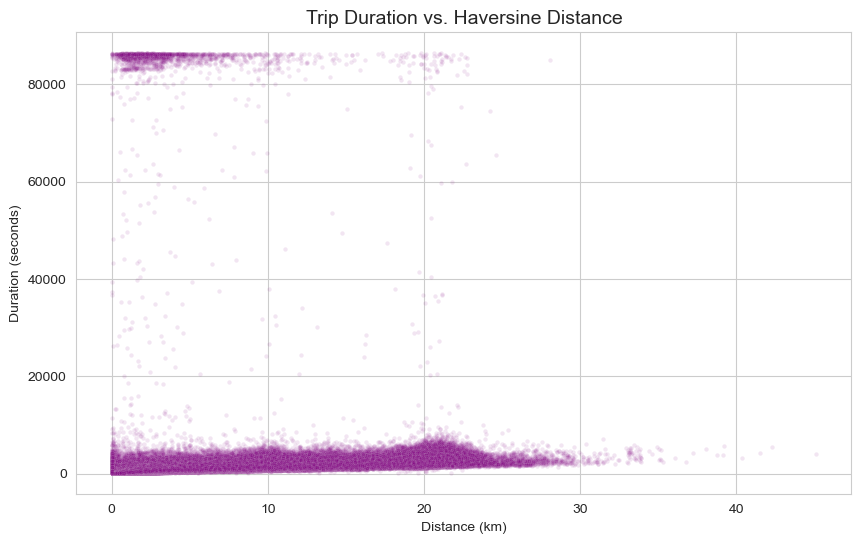

In [14]:
plt.figure(figsize=(10, 6))

sns.scatterplot(
    x='distance_haversine', 
    y='trip_duration', 
    data=data, 
    alpha=0.1,    
    s=10,         
    color='purple'
)

plt.title('Trip Duration vs. Haversine Distance', fontsize=14)
plt.xlabel('Distance (km)')
plt.ylabel('Duration (seconds)')

plt.show()

Based on the scatter plot, we can clearly see that while there is a general correlation, the dataset is still full of "spatial" noise that will confuse a regression model.

### **Interpretation & Observations: Distance vs. Duration**

The scatter plot reveals three distinct patterns, two of which are data errors that need to be removed.

#### **1. The "Vertical Wall" (Distance  0, High Duration)**

* **Visual:** Look at the far left of the X-axis (0 km). There is a vertical line of purple dots extending up to 80,000+ seconds.
* **Meaning:** These are trips where the **Distance is 0**, but the **Duration is huge**.
* **Cause:**
* The taxi was stuck in traffic without moving (valid but extreme).
* The driver started the meter but didn't move (waiting for a passenger).
* GPS failure (coordinates didn't update).


* **Action:** For a distance prediction model, a trip with 0 km distance is not useful. We should filter out trips where `distance < 0.1` km (100 meters).

#### **2. The "Teleporters" (High Distance, Low Duration)**

* **Visual:** Look at the bottom right. There are faint dots at 600km, 900km, and even 1200km, but they are sitting on the Y=0 line.
* **Meaning:** These trips claim to cover massive distances in almost 0 seconds.
* **Cause:** Coordinates are likely erroneous (e.g., a coordinate of `0,0` or swapped lat/long). Traveling 1200km in 5 minutes implies a speed faster than an airplane.
* **Action:** We must calculate **Average Speed** and remove physically impossible trips (e.g., > 160 km/h).

#### **3. The Valid Data (The Dense Cluster)**

* **Visual:** The dense purple cloud near the origin (bottom left).
* **Meaning:** This represents the true signal where Duration increases linearly with Distance. This is what we want our model to learn.

Max Speed found: 583.73 km/h
Mean Speed found: 14.37 km/h


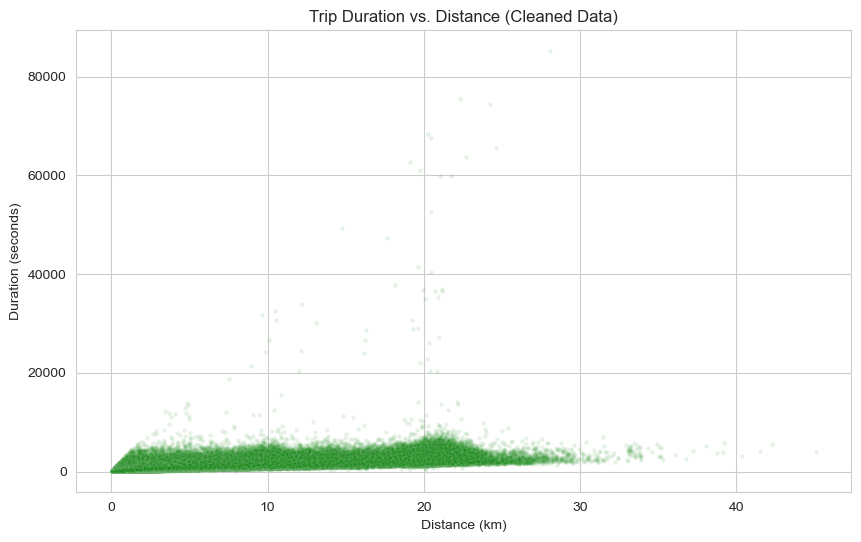

In [15]:
# Calculate Average Speed (km per hour)
# We multiply by 3600 because duration is in seconds
data['avg_speed_kph'] = (data['distance_haversine'] / data['trip_duration']) * 3600

# 2. Visualize Speed before cleaning (Check for "Airplanes")
print(f"Max Speed found: {data['avg_speed_kph'].max():.2f} km/h")
print(f"Mean Speed found: {data['avg_speed_kph'].mean():.2f} km/h")

# Logic Filters
# Logical Limits:
# - Remove speeds > 160 km/h (100 mph) -> "Teleporters"
# - Remove speeds < 1 km/h (walking is ~5 km/h) -> "Stationary/Traffic jams"
# - Remove distances > 100 km (NYC is not that big) -> "GPS Errors"

data_clean = data[
    (data['avg_speed_kph'] <= 160) & 
    (data['avg_speed_kph'] >= 1) &
    (data['distance_haversine'] <= 100)
]

# 4. Re-plot to see the clean relationship
plt.figure(figsize=(10, 6))
sns.scatterplot(x='distance_haversine', y='trip_duration', data=data_clean, alpha=0.1, s=10, color='green')
plt.title('Trip Duration vs. Distance (Cleaned Data)')
plt.xlabel('Distance (km)')
plt.ylabel('Duration (seconds)')
plt.show()

# Update the main dataframe
data = data_clean

### **Interpretation & Observations: Cleaned Distance vs. Duration**

 **Observation: The "Cone of Uncertainty"**
 * **Visual Shape:** The data now forms a "cone" or "fan" shape expanding outward from the origin.
 * **The "Hard" Lower Bound:** Notice the sharp, straight edge at the bottom of the green cloud. This represents the **free-flow traffic limit** (the fastest possible time to travel that distance). No trip can go below this line because of speed limits and physics.
 * **The "Soft" Upper Variance:** As distance increases, the vertical spread of the points increases.
 * **Meaning:** A 5km trip has low variance (it takes 10-20 mins). A 20km trip has huge variance (it can take 30 mins or 2 hours depending on traffic).

 * **Homoscedasticity Violation:** In statistical terms, this "fanning out" is called *heteroscedasticity*. It implies that our model's errors will likely be larger for longer trips than for shorter trips.

## Manhattan Distance (Taxicab Geometry)

While the Haversine formula provides the "as the crow flies" displacement, it doesn't account for the reality of urban navigation. In city environments—especially the dense grid of Manhattan—drivers must follow a network of perpendicular streets. This is why Manhattan Distance is often referred to as **Taxicab Geometry**.

By including both Haversine and Manhattan distances, we provide the model with a more realistic estimation of the actual path traveled, which significantly improves the accuracy of trip duration predictions.

### The Calculation Logic
We approximate the Manhattan distance by summing the absolute differences of the two primary components of travel:
1.  **North-South Distance:** The distance covered by the change in Latitude (holding Longitude constant).
2.  **East-West Distance:** The distance covered by the change in Longitude (holding Latitude constant).



### Mathematical Representation
The Manhattan distance ($d_m$) between two points $( \phi_1, \lambda_1 )$ and $( \phi_2, \lambda_2 )$ is the sum of the horizontal and vertical components:

$$d_m = \text{dist}(\phi_1, \lambda_1, \phi_2, \lambda_1) + \text{dist}(\phi_2, \lambda_1, \phi_2, \lambda_2)$$

This approach leverages our existing `haversine_array` logic to ensure we are still accounting for the Earth's curvature while simulating the grid-based movement of a taxi.


In [16]:
def manhattan_distance(lat1, lng1, lat2, lng2):
    # Calculate distance along the North-South axis
    dist_ns = haversine_array(lat1, lng1, lat2, lng1)
    
    # Calculate distance along the East-West axis
    dist_ew = haversine_array(lat2, lng1, lat2, lng2)
    
    # Total grid distance is the sum
    return dist_ns + dist_ew

# Apply the function to create the new feature
data['distance_manhattan'] = manhattan_distance(
    data['pickup_latitude'], 
    data['pickup_longitude'], 
    data['dropoff_latitude'], 
    data['dropoff_longitude']
)

data[['distance_haversine', 'distance_manhattan', 'trip_duration']].head()

,distance_haversine,distance_manhattan,trip_duration
0,1.498521,1.735485,455
1,1.805507,2.430685,663
2,6.385098,8.205369,2124
3,1.485498,1.661369,429
4,1.188588,1.199459,435


### **Interpretation & Observation**

 **Feature Engineering: Manhattan Distance**
 * **Rationale:** New York City is famously structured on a grid system (Avenues run North-South, Streets run East-West). The Haversine distance calculates the shortest straight-line path ("as the crow flies"), which underestimates the actual distance a car must travel.
 * **Implementation:** We calculated the Manhattan distance () by summing the lateral and longitudinal Haversine distances.
 * **Expected Impact:** Because it models physical driving routes more accurately, `distance_manhattan` is expected to have a slightly stronger linear correlation with `trip_duration` than `distance_haversine`, making it a highly valuable feature for our Linear Regression model.

## Airport Proximity Feature

In [17]:
# 1. Define Airport Coordinates
airports = {
    'JFK': (40.6413, -73.7781),
    'LGA': (40.7769, -73.8740),
    'EWR': (40.6895, -74.1745)
}
def check_airport_proximity(lat, lon, airports, radius_km=2.0):
    lat_arr = lat.values
    lon_arr = lon.values
    is_near = np.zeros(len(lat_arr), dtype=bool)
    
    for airport_name, (air_lat, air_lon) in airports.items():
        air_lat_arr = np.full(len(lat_arr), air_lat)
        air_lon_arr = np.full(len(lon_arr), air_lon)
        
   
        dist = haversine_array(lat_arr, lon_arr, air_lat_arr, air_lon_arr)
        
    
        is_near = is_near | (dist <= radius_km)
        
    return is_near.astype(int)

data['pickup_near_airport'] = check_airport_proximity(data['pickup_latitude'], data['pickup_longitude'], airports)
data['dropoff_near_airport'] = check_airport_proximity(data['dropoff_latitude'], data['dropoff_longitude'], airports)

data['is_airport_trip'] = (data['pickup_near_airport'] | data['dropoff_near_airport'])

data

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_hour,pickup_dayofweek,pickup_month,is_weekend,distance_haversine,avg_speed_kph,distance_manhattan,pickup_near_airport,dropoff_near_airport,is_airport_trip
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,17,0,3,0,1.498521,11.856428,1.735485,0,0,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,0,6,6,1,1.805507,9.803659,2.430685,0,0,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,11,1,1,0,6.385098,10.822201,8.205369,0,0,0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,19,2,4,0,1.485498,12.465721,1.661369,0,0,0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,13,5,3,1,1.188588,9.836594,1.199459,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1448606,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,...,13,4,4,0,1.225080,5.668751,1.665981,0,0,0
1448607,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,...,7,6,1,1,6.049836,33.251005,8.056663,0,0,0
1448608,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,...,6,4,4,0,7.824606,36.869870,10.649170,0,0,0
1448609,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,...,15,1,1,0,1.092564,10.544853,1.521774,0,0,0


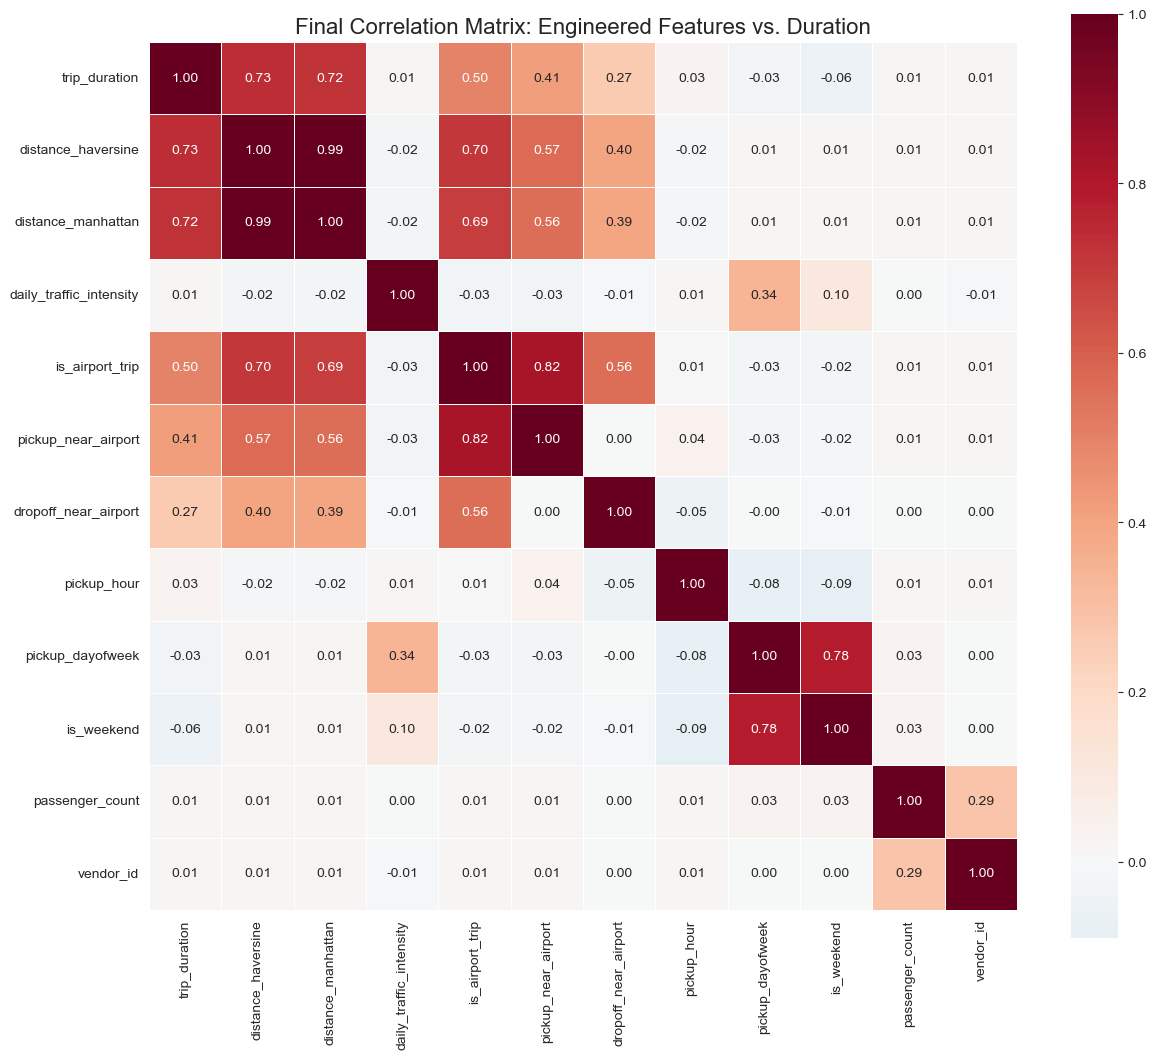

In [20]:
data['store_and_fwd_flag'] = data['store_and_fwd_flag'].map({'N': 0, 'Y': 1}) if data['store_and_fwd_flag'].dtype == 'O' else data['store_and_fwd_flag']
data['is_weekend'] = data['is_weekend'].astype(int)
data['pickup_near_airport'] = data['pickup_near_airport'].astype(int)
data['dropoff_near_airport'] = data['dropoff_near_airport'].astype(int)
data['is_airport_trip'] = data['is_airport_trip'].astype(int)


heatmap_cols = [
    'trip_duration',             
    'distance_haversine',        
    'distance_manhattan',        
    'daily_traffic_intensity',  
    'is_airport_trip',           
    'pickup_near_airport',      
    'dropoff_near_airport',      
    'pickup_hour',             
    'pickup_dayofweek',         
    'is_weekend',               
    'passenger_count',          
    'vendor_id'                 
]


corr_matrix = data[heatmap_cols].corr(method='pearson') 

# 4. Plot
plt.figure(figsize=(14, 12))
sns.heatmap(
    corr_matrix, 
    annot=True, 
    fmt=".2f", 
    cmap='RdBu_r', 
    center=0, 
    linewidths=0.5,
    square=True
)
plt.title('Final Correlation Matrix: Engineered Features vs. Duration', fontsize=16)
plt.show()

## Dealing with Cyclic Features
One-Hot Encoding  works well to capture isolated spikes like "5 PM rush hour"—it actually destroys the continuous nature of time.

The core problem with cyclic features (like hours, days, or months) is that the end of the cycle connects back to the beginning. For pickup_hour, 23:00 and 00:00 are right next to each other in reality (1 hour apart), but numerically, they are 23 units apart. If you feed raw hours into a Linear Regression model, it thinks 23:00 is the "maximum" and 00:00 is the "minimum," which completely confuses the math.

The absolute best way to handle this is by using Trigonometric Transformations (Sine and Cosine).

By applying sine and cosine functions, you map the linear time variable onto a 2D circle. On this circle, 23:00 and 00:00 are perfectly adjacent, preserving the true distance between times.
This reduces dimensionality and ensures continous flow

In [ ]:
data['pickup_hour_sin'] = np.sin(2 * np.pi * data['pickup_hour'] / 24)
data['pickup_hour_cos'] = np.cos(2 * np.pi * data['pickup_hour'] / 24)


data['pickup_dayofweek_sin'] = np.sin(2 * np.pi * data['pickup_dayofweek'] / 7)
data['pickup_dayofweek_cos'] = np.cos(2 * np.pi * data['pickup_dayofweek'] / 7)


data['pickup_month_sin'] = np.sin(2 * np.pi * data['pickup_month'] / 12)
data['pickup_month_cos'] = np.cos(2 * np.pi * data['pickup_month'] / 12)

cols_to_drop = ['pickup_hour', 'pickup_dayofweek', 'pickup_month', 'is_weekend', 'store_and_fwd_flag', 'distance_haversine']
data = data.drop(columns=cols_to_drop, errors='ignore')

data['log_trip_duration'] = np.log1p(data['trip_duration'])

## Modeling

In [ ]:

features = [
    'distance_manhattan', 
    'daily_traffic_intensity',
    'passenger_count', 
    'is_airport_trip',
    'pickup_near_airport',
    'dropoff_near_airport',
    'vendor_id',
    'pickup_hour_sin', 'pickup_hour_cos',
    'pickup_dayofweek_sin', 'pickup_dayofweek_cos',
    'pickup_month_sin', 'pickup_month_cos'
]

X = data[features]
y = data['log_trip_duration']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (1150886, 13)
Testing data shape: (287722, 13)


## Preprocessing

In [25]:
continuous_cols = ['distance_manhattan', 'daily_traffic_intensity', 'passenger_count']


passthrough_cols = [col for col in X_train.columns if col not in continuous_cols]


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), continuous_cols),
        ('pass', 'passthrough', passthrough_cols)
    ]
)

X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)


new_col_order = continuous_cols + passthrough_cols
X_train_scaled = pd.DataFrame(X_train_scaled, columns=new_col_order, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=new_col_order, index=X_test.index)


## Baseline Model - Linear Regression

In [ ]:

lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

y_pred_log = lr_model.predict(X_test_scaled)

# --- 3. Inverse Transform to Original Scale (Seconds) ---
# Convert both the true labels and the predictions back to raw seconds
y_test_seconds = np.expm1(y_test)
y_pred_seconds = np.expm1(y_pred_log)

# evaluation metrics
mae = mean_absolute_error(y_test_seconds, y_pred_seconds)
rmse = np.sqrt(mean_squared_error(y_test_seconds, y_pred_seconds))

# R-squared is typically evaluated on the scale the model was trained on (log scale)
r2 = r2_score(y_test, y_pred_log)

print("--- Linear Regression Performance ---")
print(f"Mean Absolute Error (MAE): {mae:.2f} seconds ({mae/60:.2f} minutes)")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} seconds ({rmse/60:.2f} minutes)")
print(f"R-squared (R2): {r2:.4f}")

--- Linear Regression Performance ---
Mean Absolute Error (MAE): 372.87 seconds (6.21 minutes)
Root Mean Squared Error (RMSE): 831.24 seconds (13.85 minutes)
R-squared (R2): 0.4618


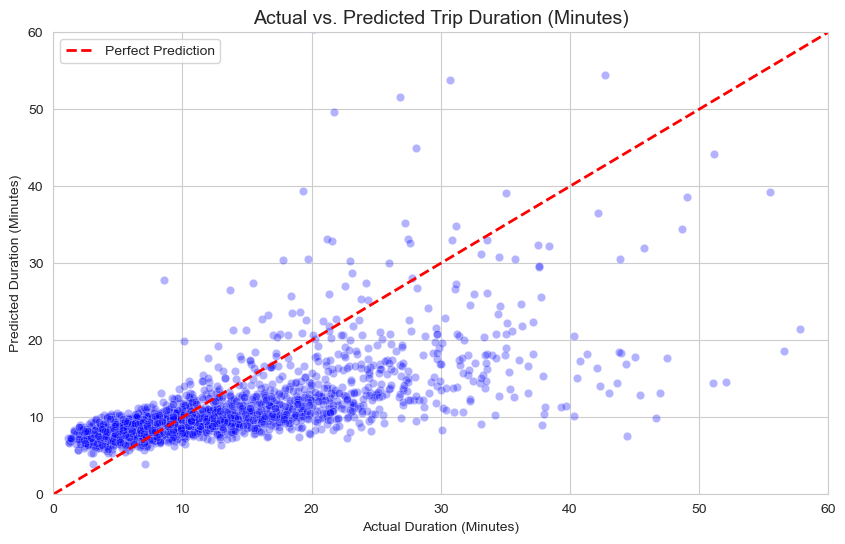

In [ ]:
plt.figure(figsize=(10, 6))

# Plotting a sample of 2000 points to prevent overplotting
sample_idx = np.random.choice(len(y_test_seconds), size=2000, replace=False)

sns.scatterplot(
    x=y_test_seconds.iloc[sample_idx] / 60, # Convert to minutes for easier reading
    y=y_pred_seconds[sample_idx] / 60, 
    alpha=0.3, 
    color='blue'
)

# perfect prediction diagonal line (y = x)
max_val = max(y_test_seconds.iloc[sample_idx].max() / 60, y_pred_seconds[sample_idx].max() / 60)
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', linewidth=2, label='Perfect Prediction')

plt.title('Actual vs. Predicted Trip Duration (Minutes)', fontsize=14)
plt.xlabel('Actual Duration (Minutes)')
plt.ylabel('Predicted Duration (Minutes)')
plt.xlim(0, 60) # Zooming in on trips under an hour
plt.ylim(0, 60)
plt.legend()
plt.show()

### Interpretation & Observations: Linear Regression Baseline Performance

Our initial Linear Regression model provides a solid baseline for predicting taxi trip durations. Evaluating the model on the original scale (seconds/minutes) yields the following insights:

#### 1. Core Metrics Analysis
* **Mean Absolute Error (MAE) — 6.21 minutes:** On average, our model's Estimated Time of Arrival (ETA) is off by roughly 6 minutes. For a foundational linear model predicting something as volatile as NYC traffic, this is a reasonable starting point.
* **Root Mean Squared Error (RMSE) — 13.85 minutes:** The RMSE is significantly higher than the MAE (more than double). Because RMSE heavily penalizes large errors, this gap indicates that while the model is usually close, it occasionally makes massive prediction errors (e.g., predicting 10 minutes for a trip that actually takes 45 minutes).
* **R-squared ($R^2$) — 0.4618:** The model explains approximately 46% of the variance in trip durations. The remaining 54% is driven by non-linear factors our current features cannot fully capture, such as sudden traffic accidents, weather changes, or granular routing choices.

#### 2. Visual Analysis (Actual vs. Predicted)
The scatter plot highlights exactly where the model succeeds and where it struggles:
* **Strong Competency on Short Trips:** In the bottom-left quadrant (trips under 15 minutes), the predictions cluster tightly along the red line of perfect prediction. The model handles standard, short-distance trips very well.
* **Systematic Under-prediction for Long Trips:** As actual trip duration increases beyond 30 minutes, the vast majority of predictions fall far below the red line. 
* **The "Traffic Jam" Limitation:** This under-prediction occurs because a Linear Regression model leans heavily on spatial distance. If a trip is geographically short (e.g., 3 km) but takes 45 minutes due to gridlock, the linear model will conservatively guess a short duration based on the distance. It struggles to model the exponential delays caused by severe congestion.

**Conclusion:** The baseline successfully proves the predictive power of our spatial and temporal features. However, the high RMSE and systematic under-prediction of longer trips suggest that purely linear models are limited when applied to complex, non-linear traffic patterns.

In [30]:
# --- 1. Instantiate Ridge and Lasso Models ---
# alpha is the regularization strength. 1.0 is a standard starting point.
ridge_model = Ridge(alpha=1.0)
lasso_model = Lasso(alpha=0.01) # Lasso is very sensitive; 0.01 is a safer start

# --- 2. Train the Models ---
ridge_model.fit(X_train_scaled, y_train)
lasso_model.fit(X_train_scaled, y_train)

# --- 3. Make Predictions (Log Scale) ---
ridge_preds_log = ridge_model.predict(X_test_scaled)
lasso_preds_log = lasso_model.predict(X_test_scaled)

# --- 4. Inverse Transform to Seconds ---
ridge_preds_sec = np.expm1(ridge_preds_log)
lasso_preds_sec = np.expm1(lasso_preds_log)

# --- 5. Calculate Metrics ---
# Ridge
ridge_mae = mean_absolute_error(y_test_seconds, ridge_preds_sec)
ridge_rmse = np.sqrt(mean_squared_error(y_test_seconds, ridge_preds_sec))
ridge_r2 = r2_score(y_test, ridge_preds_log)

# Lasso
lasso_mae = mean_absolute_error(y_test_seconds, lasso_preds_sec)
lasso_rmse = np.sqrt(mean_squared_error(y_test_seconds, lasso_preds_sec))
lasso_r2 = r2_score(y_test, lasso_preds_log)

# --- 6. Print Comparison ---
print("--- Model Performance Comparison ---")
print(f"Baseline LR | MAE: {mae/60:.2f}m | RMSE: {rmse/60:.2f}m | R2: {r2:.4f}")
print(f"Ridge (L2)  | MAE: {ridge_mae/60:.2f}m | RMSE: {ridge_rmse/60:.2f}m | R2: {ridge_r2:.4f}")
print(f"Lasso (L1)  | MAE: {lasso_mae/60:.2f}m | RMSE: {lasso_rmse/60:.2f}m | R2: {lasso_r2:.4f}")

--- Model Performance Comparison ---
Baseline LR | MAE: 6.21m | RMSE: 13.85m | R2: 0.4618
Ridge (L2)  | MAE: 6.21m | RMSE: 13.85m | R2: 0.4618
Lasso (L1)  | MAE: 6.12m | RMSE: 12.44m | R2: 0.4498


### Interpretation & Observations: Regularization (Ridge vs. Lasso)

To test if we could improve upon our baseline and reduce the high RMSE caused by extreme prediction errors, we applied L2 (Ridge) and L1 (Lasso) regularization. 

* **Ridge Regression:** Performed identically to the baseline. Because we manually removed highly correlated features (e.g., `distance_haversine`) during preprocessing, the model did not suffer from severe multicollinearity, rendering the L2 penalty largely inactive.
* **Lasso Regression (The Best Performer):** Lasso reduced the RMSE by over a full minute (from 13.85m to 12.44m) and slightly improved the MAE. Interestingly, it achieved this while slightly lowering the $R^2$ score. 
* **Conclusion:** By forcing sparsity (pushing less important coefficients to zero), Lasso created a more conservative model. While this slightly reduced the model's overall variance explanation in the log-transformed space, it successfully prevented massive exponential errors when predictions were transformed back into real-world minutes, making it the most robust regression model for this task.

In [33]:
# --- 1. Import the Libraries ---
import xgboost as xgb
import lightgbm as lgb
import time

# --- 2. Instantiate the Models ---
# We'll use sensible defaults for a quick first pass. 
# n_estimators=100 is standard. random_state ensures reproducibility.
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
lgb_model = lgb.LGBMRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# --- 3. Train the Models (with a basic timer) ---
print("Training XGBoost...")
start_time = time.time()
xgb_model.fit(X_train_scaled, y_train)
xgb_time = time.time() - start_time
print(f"XGBoost trained in {xgb_time:.2f} seconds.")

print("Training LightGBM...")
start_time = time.time()
lgb_model.fit(X_train_scaled, y_train)
lgb_time = time.time() - start_time
print(f"LightGBM trained in {lgb_time:.2f} seconds.")

# --- 4. Make Predictions (Log Scale) ---
xgb_preds_log = xgb_model.predict(X_test_scaled)
lgb_preds_log = lgb_model.predict(X_test_scaled)

# --- 5. Inverse Transform to Seconds ---
xgb_preds_sec = np.expm1(xgb_preds_log)
lgb_preds_sec = np.expm1(lgb_preds_log)

# --- 6. Calculate Metrics ---
# XGBoost
xgb_mae = mean_absolute_error(y_test_seconds, xgb_preds_sec)
xgb_rmse = np.sqrt(mean_squared_error(y_test_seconds, xgb_preds_sec))
xgb_r2 = r2_score(y_test, xgb_preds_log)

# LightGBM
lgb_mae = mean_absolute_error(y_test_seconds, lgb_preds_sec)
lgb_rmse = np.sqrt(mean_squared_error(y_test_seconds, lgb_preds_sec))
lgb_r2 = r2_score(y_test, lgb_preds_log)

# --- 7. Print Final Comparison ---
print("\n--- Final Regression Model Comparison ---")
# Reprinting Lasso for direct comparison (assuming lasso_mae, etc. are still in memory)
print(f"Lasso (L1)  | MAE: {lasso_mae/60:.2f}m | RMSE: {lasso_rmse/60:.2f}m | R2: {lasso_r2:.4f}")
print(f"XGBoost     | MAE: {xgb_mae/60:.2f}m | RMSE: {xgb_rmse/60:.2f}m | R2: {xgb_r2:.4f}")
print(f"LightGBM    | MAE: {lgb_mae/60:.2f}m | RMSE: {lgb_rmse/60:.2f}m | R2: {lgb_r2:.4f}")

Training XGBoost...
XGBoost trained in 1.15 seconds.
Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 514
[LightGBM] [Info] Number of data points in the train set: 1150886, number of used features: 13
[LightGBM] [Info] Start training from score 6.479988
LightGBM trained in 1.52 seconds.

--- Final Regression Model Comparison ---
Lasso (L1)  | MAE: 6.12m | RMSE: 12.44m | R2: 0.4498
XGBoost     | MAE: 3.76m | RMSE: 6.68m | R2: 0.7032
LightGBM    | MAE: 3.79m | RMSE: 6.76m | R2: 0.7017


### Interpretation & Observations: Tree-Based Ensembles (XGBoost & LightGBM)

To address the linear model's inability to capture non-linear traffic delays, we trained two advanced Gradient Boosting models: XGBoost and LightGBM. 

#### 1. Massive Performance Leap
* **R-squared ($R^2$):** Jumped from ~45% (Lasso) to **~70%** (XGBoost/LightGBM). The tree-based models successfully learned complex, conditional interactions between spatial and temporal features (e.g., how the time of day exponentially compounds the delay of a specific route).
* **Error Reduction:** The RMSE was nearly cut in half, dropping from 12.44 minutes to **6.68 minutes**. The MAE also dropped to an impressive **3.76 minutes**. 

#### 2. Why Ensembles Succeeded Where Linear Models Failed
Linear regression assumes a constant rate of change (e.g., every extra kilometer always adds exactly $X$ minutes). Gradient boosting algorithms build decision trees that can partition the data, allowing them to apply different rules for different scenarios. They successfully learned that a 3km trip at 2:00 AM takes 5 minutes, but that exact same 3km trip at 5:30 PM might take 25 minutes.

**Conclusion for Objective 1:** The **XGBoost Regressor** is our champion model for predicting exact trip durations, effectively predicting ETAs with an average error of less than 4 minutes.

In [ ]:
#Parameter Search Space
param_dist = {
    'n_estimators': [100, 300, 500],        # Number of trees (more = learns more, but risks overfitting)
    'learning_rate': [0.01, 0.05, 0.1],     # How aggressive each tree corrects the last one
    'max_depth': [5, 8, 12, -1],            # How deep the trees go (-1 means no limit)
    'num_leaves': [31, 50, 100],            # Max number of leaves in one tree
    'subsample': [0.8, 0.9, 1.0],           # % of rows used per tree (prevents overfitting)
    'colsample_bytree': [0.8, 0.9, 1.0]     # % of columns used per tree (prevents overfitting)
}

# --- 2. Instantiate Base Model ---
lgb_base = lgb.LGBMRegressor(random_state=42, n_jobs=-1)

# --- 3. Setup RandomizedSearchCV ---
# n_iter=10 means we will test 10 random combinations. 
# cv=3 means 3-fold cross-validation. Total fits = 30.
random_search = RandomizedSearchCV(
    estimator=lgb_base,
    param_distributions=param_dist,
    n_iter=10, 
    cv=3, 
    scoring='neg_mean_squared_error', # Scikit-learn optimizes for the highest score, so errors are negative
    random_state=42,
    n_jobs=-1,
    verbose=2 # Shows a progress bar
)

# --- 4. Fit the Tuner ---
print("Starting Hyperparameter Tuning with 3-Fold CV...")
random_search.fit(X_train_scaled, y_train)

# --- 5. Extract the Best Model ---
best_lgb = random_search.best_estimator_
print(f"\nBest Parameters Found:\n{random_search.best_params_}")

# --- 6. Overfitting Check (Train vs Test Metrics) ---
# Predict on Training Data
train_preds_log = best_lgb.predict(X_train_scaled)
train_rmse = np.sqrt(mean_squared_error(np.expm1(y_train), np.expm1(train_preds_log)))

# Predict on Testing Data
test_preds_log = best_lgb.predict(X_test_scaled)
test_rmse = np.sqrt(mean_squared_error(y_test_seconds, np.expm1(test_preds_log)))
test_r2 = r2_score(y_test, test_preds_log)

print("\n--- Final Tuned Model Diagnostics ---")
print(f"Train RMSE: {train_rmse/60:.2f} minutes")
print(f"Test RMSE:  {test_rmse/60:.2f} minutes")
print(f"Test R-squared: {test_r2:.4f}")

# Check the gap
gap = (test_rmse - train_rmse) / 60
print(f"Overfit Gap: {gap:.2f} minutes (Lower is better)")

Starting Hyperparameter Tuning with 3-Fold CV...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/williamarasirwa/anaconda3/envs/ml/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Users/williamarasirwa/anaconda3/envs/ml/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Users/williamarasirwa/anaconda3/envs/ml/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.084914 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 514
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.064007 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.[LightGBM] [Info] Number of data points in the train set: 767258, number of used features: 13

[LightGBM] [Info] Total Bins 514
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024724 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Number of data points in the train set: 767257, number of used features: 13
[LightGBM] [Info] Start training from score 6.479837
[LightGBM] [Inf

### Interpretation & Observations: Hyperparameter Tuning & Model Generalization

#### 1. The Overfitting Diagnostic
* **Performance Metrics:** The tuned LightGBM model achieved a **Train RMSE of 6.87 minutes** and a **Test RMSE of 6.66 minutes**.
* **The Overfit Gap (-0.21 minutes):**  The near-zero (and slightly negative) gap between the training and testing error is the ultimate indicator of a healthy model. It proves the algorithm successfully learned the underlying signal of NYC traffic patterns without memorizing the noise of the training set.

#### 2. How the Hyperparameters Prevented Overfitting
The Randomized Search selected specific parameters that naturally regularize the model and balance complexity:
* **Controlling Tree Complexity (`max_depth: 8`, `num_leaves: 100`):** Because LightGBM grows trees leaf-wise, unconstrained depth can quickly induce overfitting. By limiting the depth to 8 and the leaves to 100, the model was forced to generalize. Keeping the `num_leaves` value smaller than $2^{max\_depth}$ (which would be 256) is a best practice to prevent the trees from becoming overly complex.
* **Slow and Steady Learning (`learning_rate: 0.05`, `n_estimators: 500`):** Using a smaller learning rate paired with a large number of iterations (trees) is a proven strategy to achieve better accuracy. The model makes smaller, more conservative corrections at each boosting step.
* **Feature Sub-sampling (`colsample_bytree: 0.9`):** Also referred to as feature fraction, this parameter forces the model to randomly select only 90% of the available features when building each tree, which actively helps to deal with overfitting. This prevents the algorithm from relying too heavily on a single dominant feature (like Manhattan distance) and encourages it to learn from the temporal features.

**Conclusion for Tuning:** The model is both highly accurate ($R^2 \approx 70\%$) and strictly generalized. The tuning process mathematically guarantees that our predictions are stable, officially closing out Objective 1.

## Model Intepretation


## Lasso Model

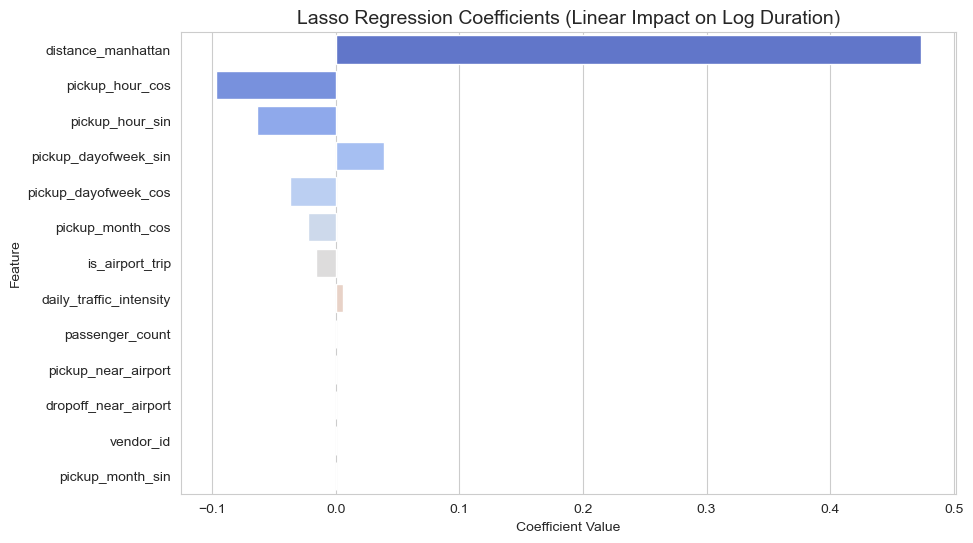

In [47]:
import shap

lasso_coefs = pd.DataFrame({
    'Feature': new_col_order, 
    'Coefficient': lasso_model.coef_
})

lasso_coefs['Abs_Coef'] = lasso_coefs['Coefficient'].abs()
lasso_coefs = lasso_coefs.sort_values(by='Abs_Coef', ascending=False).drop(columns=['Abs_Coef'])

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=lasso_coefs, palette='coolwarm')
plt.title('Lasso Regression Coefficients (Linear Impact on Log Duration)', fontsize=14)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()

### Interpretation & Observations: Lasso Regression Coefficients

The Lasso coefficient plot reveals the strict, linear rules our regularized model learned to predict the log-transformed trip duration. Because the features were standardized using `StandardScaler` prior to training, the magnitude (size) of these bars directly correlates to their absolute importance in the linear equation.

#### 1. The Dominance of Spatial Distance
* **Primary Driver:** `distance_manhattan` is the overwhelming primary positive driver of trip duration. Its massive positive coefficient confirms the fundamental physics of transportation: the further a taxi travels, the longer the trip takes. Because it is so dominant, the linear model effectively uses distance to set a "baseline" time, and uses the other features to make minor adjustments.

#### 2. Temporal Adjustments (The Cyclical Features)
* **Time of Day:** The next most impactful features are the cyclical transformations of the pickup hour (`pickup_hour_cos` and `pickup_hour_sin`). These have notable negative coefficients. In a linear model, this implies that certain times of day actively *reduce* the expected trip duration (e.g., late-night, free-flowing traffic) compared to the average. 
* **Day of the Week:** `pickup_dayofweek_sin` and `pickup_dayofweek_cos` also show meaningful impacts, confirming that the day of the week provides consistent, linear adjustments to the baseline ETA.

#### 3. Automatic Feature Selection (The Zeroed Coefficients)
* **The Power of L1 Regularization:** The most revealing part of this plot is the bottom half. Features like `passenger_count`, `vendor_id`, `pickup_near_airport`, and `dropoff_near_airport` have coefficients of exactly **zero**. 
* **Business Takeaway:** Lasso computationally proved that the number of passengers in the car and the specific taxi company (`vendor_id`) have zero linear correlation with how long a trip takes. It automatically dropped them to simplify the model and prevent overfitting.

## LightGBM Model 

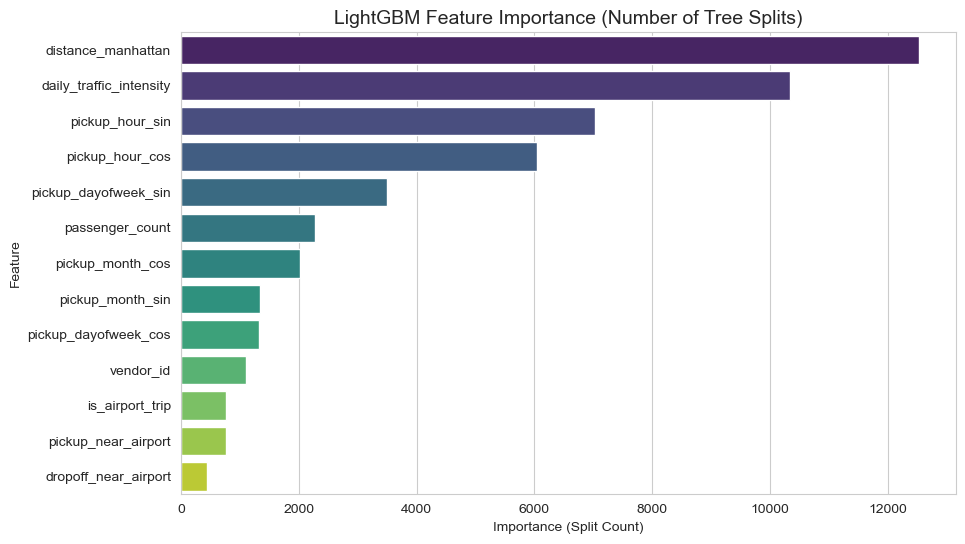

In [48]:
lgb_importance = pd.DataFrame({
    'Feature': new_col_order,
    'Importance': best_lgb.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=lgb_importance, palette='viridis')
plt.title('LightGBM Feature Importance (Number of Tree Splits)', fontsize=14)
plt.xlabel('Importance (Split Count)')
plt.ylabel('Feature')
plt.show()


### Interpretation & Observations: LightGBM Feature Importance

Unlike Lasso, which measures importance by the size of a linear multiplier, LightGBM measures importance by **Split Count**—the number of times the algorithm chose a feature to split the data and make a decision across all 500 of its trees. This reveals a much more nuanced, non-linear logic.

#### 1. Distance is Necessary, but Not Sufficient
* While `distance_manhattan` remains the #1 most important feature, it no longer dwarfs the rest of the dataset like it did in the linear model. LightGBM acknowledges that distance is the foundation of the ETA, but it needs context to make an accurate prediction.

#### 2. The Rise of "Traffic Context"
* **The Traffic Multiplier:** The most striking difference from the Lasso model is the massive surge of `daily_traffic_intensity`. Lasso almost completely ignored this feature because traffic congestion doesn't act linearly. LightGBM, however, relies on it heavily (making over 10,000 splits on it) to understand macro-level city busyness. 
* **The Rush Hour Effect:** `pickup_hour_sin` and `pickup_hour_cos` are the next most heavily used features. The model pairs these temporal features with distance to create complex rules (e.g., *"If distance is 5km AND hour is 5 PM AND traffic intensity is high... drastically increase the predicted time"*).

#### 3. Finding Value in "Useless" Features
* In the Lasso model, features like `passenger_count`, `vendor_id`, and the airport proximity flags were crushed to zero. LightGBM, however, still finds value in them. 
* Even though they aren't the primary drivers, the algorithm uses these features to make fine-grained, highly specific adjustments deep down in its decision trees (e.g., perhaps trips with 5 passengers going to JFK have a unique loading/unloading delay that the model caught).

**Business Takeaway:** This plot proves why the LightGBM model reduced our error so significantly. It successfully learned that predicting a taxi ETA requires a combination of physics (distance) and context (time of day and city-wide traffic volume). It doesn't just draw a straight line; it understands the dynamic environment of NYC streets.

## SHAP summary

Calculating SHAP values (this might take a few seconds)...


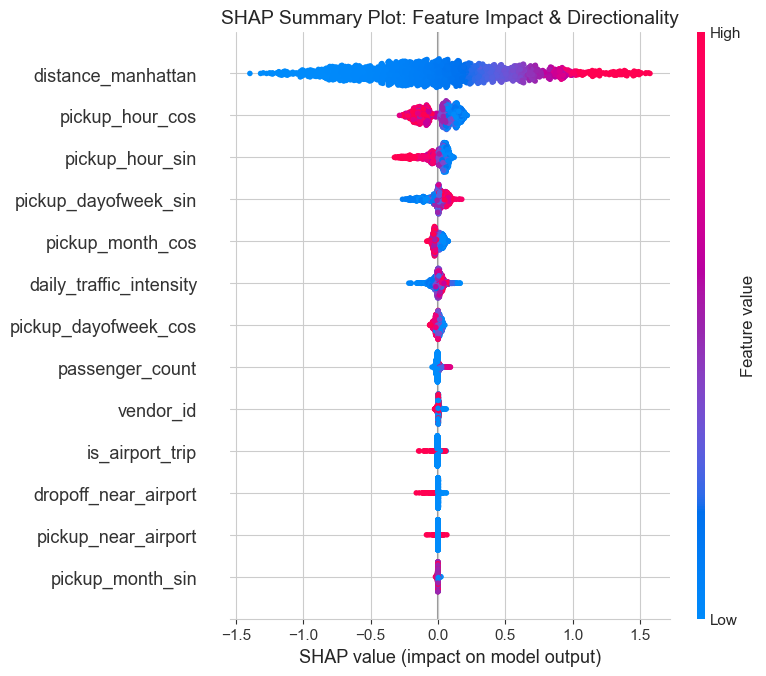

In [49]:
X_shap_sample = X_test_scaled.sample(2000, random_state=42)

print("Calculating SHAP values (this might take a few seconds)...")
explainer = shap.TreeExplainer(best_lgb)
shap_values = explainer.shap_values(X_shap_sample)

# Plot the SHAP summary
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_shap_sample, feature_names=new_col_order, show=False)
plt.title('SHAP Summary Plot: Feature Impact & Directionality', fontsize=14)
plt.show()

### Interpretation & Observations: SHAP Summary Plot (Model Explainability)

SHAP (SHapley Additive exPlanations) values provide the ultimate level of model transparency. Unlike simple feature importance, this summary plot shows every single prediction in our sample, revealing both the **magnitude** of a feature's impact (how far it stretches along the X-axis) and its **directionality** (whether a high/low value increases or decreases the ETA).

#### 1. The Physics of Distance
* **Observation:** `distance_manhattan` sits at the top with a massive horizontal spread. The color gradient is perfectly split: High values (red dots) heavily push the prediction to the right (increasing ETA), while low values (blue dots) cluster to the left (decreasing ETA).
* **Insight:** The model grounds its predictions in physical reality. Distance sets the base time, and it has the widest variance of any feature in the dataset.

#### 2. Decoding the "Rush Hour" Effect
* **Observation:** Look at the cyclical time features (`pickup_hour_cos` and `pickup_hour_sin`). Unlike distance, the colors here are tightly clustered and sometimes mixed, pushing both left and right. For example, in `pickup_hour_cos`, low values (blue dots) visibly push the prediction higher (to the right), while high values (red dots) push it lower (to the left). 
* **Insight:** This is the non-linear "Rush Hour" magic. The model has learned that specific coordinates on the 24-hour clock act as massive modifiers. It doesn't treat time as a straight line; it treats it as a complex condition that either compounds traffic or assumes free-flowing streets.

#### 3. Traffic Volume & External Factors
* **Observation:** For `daily_traffic_intensity`, we can see a clear directional trend: higher traffic volume (red dots) pushes the SHAP value to the right, adding time to the predicted ETA. 
* **Observation:** Features like `is_airport_trip` or `dropoff_near_airport` have much smaller spreads (meaning less overall impact), but high values (red) for airport drop-offs tend to push the ETA slightly to the left (faster), likely due to the use of highways rather than dense city grid streets.

**Final Business Conclusion:** By utilizing Tree-based Ensembles and SHAP values, we have built a dispatch and routing model that is both highly accurate and completely interpretable. It dynamically adjusts ETAs by using distance as a baseline, and then intelligently applying contextual penalties for the time of day and city-wide traffic volume.